In [41]:
import cv2
import os
import torch

from skimage.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
!pip install lpips 
import lpips
loss_alex = lpips.LPIPS(net='alex')
loss_alex.cuda()
loss_vgg = lpips.LPIPS(net='vgg')
loss_vgg.cuda()

In [73]:
name = "B660MBazooka"
folder_fake = f'/content/drive/MyDrive/{name}_30/{name}_30_results'
folder_real = f'/content/drive/MyDrive/nerf_dataset/{name}/images'

img_fake = []
for img in os.listdir(folder_fake):
  if img.endswith(".png"):
    img_fake.append(img)

img_real = '0001.png'
print(img_fake)

['000.png', '000_d.png', '001.png', '001_d.png', '002.png', '002_d.png', '003.png', '003_d.png', '004.png', '004_d.png', '005.png', '005_d.png', '006.png', '006_d.png', '007.png', '007_d.png', '008.png', '008_d.png', '009.png', '009_d.png', '010.png', '010_d.png', '011.png', '011_d.png', '012.png', '012_d.png', '013.png', '013_d.png', '014.png', '014_d.png', '015.png', '015_d.png', '016.png', '016_d.png', '017.png', '017_d.png', '018.png', '018_d.png', '019.png', '019_d.png', '020.png', '020_d.png', '021.png', '021_d.png', '022.png', '022_d.png', '023.png', '023_d.png', '024.png', '024_d.png', '025.png', '025_d.png', '026.png', '026_d.png', '027.png', '027_d.png', '028.png', '028_d.png', '029.png', '029_d.png', '030.png', '030_d.png', '031.png', '031_d.png', '032.png', '032_d.png', '033.png', '033_d.png', '034.png', '034_d.png', '035.png', '035_d.png', '036.png', '036_d.png', '037.png', '037_d.png', '038.png', '038_d.png', '039.png', '039_d.png', '040.png', '040_d.png', '041.png', '041

In [74]:
def lpips_(img1, img2): 
  img_1 = torch.tensor(img1).reshape([1,3,1080,1920]).cuda()
  img_2 = torch.tensor(img2).reshape([1,3,1080,1920]).cuda()
  #img_1 = torch.tensor(img1).cuda()
  #img_2 = torch.tensor(img2).cuda()
  loss1 = loss_alex.forward(img_1, img_2)
  loss2 = loss_vgg.forward(img_1, img_2)
  return float(loss1), float(loss2)

def psnr_mse_ssim(img1, img2):
  psnr = peak_signal_noise_ratio(img1, img2, data_range=255)
  mse = mean_squared_error(img1, img2)
  ssim = structural_similarity(img1, img2, data_range=255, multichannel=True)
  return mse, psnr, ssim

def summarize_results(img1, img2): 
  MSE, PSNR, SSIM = psnr_mse_ssim(img1, img2)
  LPIPS_alex, LPIPS_vgg = lpips_(img1, img2)   

  return MSE, PSNR, SSIM, LPIPS_alex, LPIPS_vgg 

In [75]:
df1 = pd.DataFrame(columns=["name", "mse", "psnr", "ssim", "lpips_alex", "lpips_vgg"])
df1

,name,mse,psnr,ssim,lpips_alex,lpips_vgg


In [76]:
for fake in img_fake: 
  img1 = cv2.imread(os.path.join(folder_real, img_real))
  img2 = cv2.imread(os.path.join(folder_fake, fake))
  #print(img1.shape, img2.shape)
  if img1.shape != img2.shape:
    img2 = np.flipud(np.rot90(img2))

  MSE, PSNR, SSIM, LPIPS_alex, LPIPS_vgg = summarize_results(img1, img2)
  print(f"Name:{fake}, MSE:{MSE}, PSNR:{PSNR}, SSIM:{SSIM}, LPIPS:{LPIPS_alex, LPIPS_vgg}")

  df2 = pd.DataFrame(data=[[fake, MSE, PSNR, SSIM, LPIPS_alex, LPIPS_vgg]], columns=["name", "mse", "psnr", "ssim", "lpips_alex", "lpips_vgg"])
  df1 = pd.concat([df1,df2], ignore_index= True)

print(df1.head())

Name:000.png, MSE:4022.0435013181586, PSNR:12.086335973719152, SSIM:0.30124066512230424, LPIPS:(0.1731753647327423, 0.2009171098470688)
Name:000_d.png, MSE:14459.560027649177, PSNR:6.529252823264907, SSIM:0.2331126847236976, LPIPS:(0.33564627170562744, 0.43508487939834595)
Name:001.png, MSE:5390.002486657665, PSNR:10.81491395320976, SSIM:0.27826715312690553, LPIPS:(0.18488752841949463, 0.23265619575977325)
Name:001_d.png, MSE:14101.163969746656, PSNR:6.638253982285436, SSIM:0.23111668785814699, LPIPS:(0.33310627937316895, 0.4374127686023712)
Name:002.png, MSE:5926.364667245371, PSNR:10.402919894411056, SSIM:0.2781235359177554, LPIPS:(0.183724045753479, 0.24132204055786133)
Name:002_d.png, MSE:14422.810780767746, PSNR:6.540304550183967, SSIM:0.2328097906763207, LPIPS:(0.3171519637107849, 0.4258691668510437)
Name:003.png, MSE:7271.085801343878, PSNR:9.514810913677218, SSIM:0.2582426155586938, LPIPS:(0.19183945655822754, 0.2706948518753052)
Name:003_d.png, MSE:14115.451820505401, PSNR:6.6

In [77]:
df_mse = df1[df1['mse']==df1['mse'].min()]
df_psnr = df1[df1['psnr']==df1['psnr'].max()]
df_ssim = df1[df1['ssim']==df1['ssim'].max()]
df_lpips_alex = df1[df1['lpips_alex']==df1['lpips_alex'].min()]
df_lpips_vgg = df1[df1['lpips_vgg']==df1['lpips_vgg'].min()]
df3 = pd.concat([df_mse, df_psnr, df_ssim, df_lpips_alex, df_lpips_vgg], ignore_index= True)
name = list(df3['name'])
name[0] = f"{name[0]}, MSE:{df1['mse'].min():0.4f}"
name[1] = f"{name[1]}, PSNR:{df1['psnr'].max():0.4f}"
name[2] = f"{name[2]}, SSIM:{df1['ssim'].max():0.4f}"
name[3] = f"{name[3]}, lpips_alex:{df1['lpips_alex'].min():0.4f}"
name[4] = f"{name[4]}, lpips_vgg:{df1['lpips_vgg'].min():0.4f}"
print(list(df3['name']))
print(name)

['000.png', '000.png', '042.png', '000.png', '000.png']
['000.png, MSE:4022.0435', '000.png, PSNR:12.0863', '042.png, SSIM:0.3022', '000.png, lpips_alex:0.1732', '000.png, lpips_vgg:0.2009']


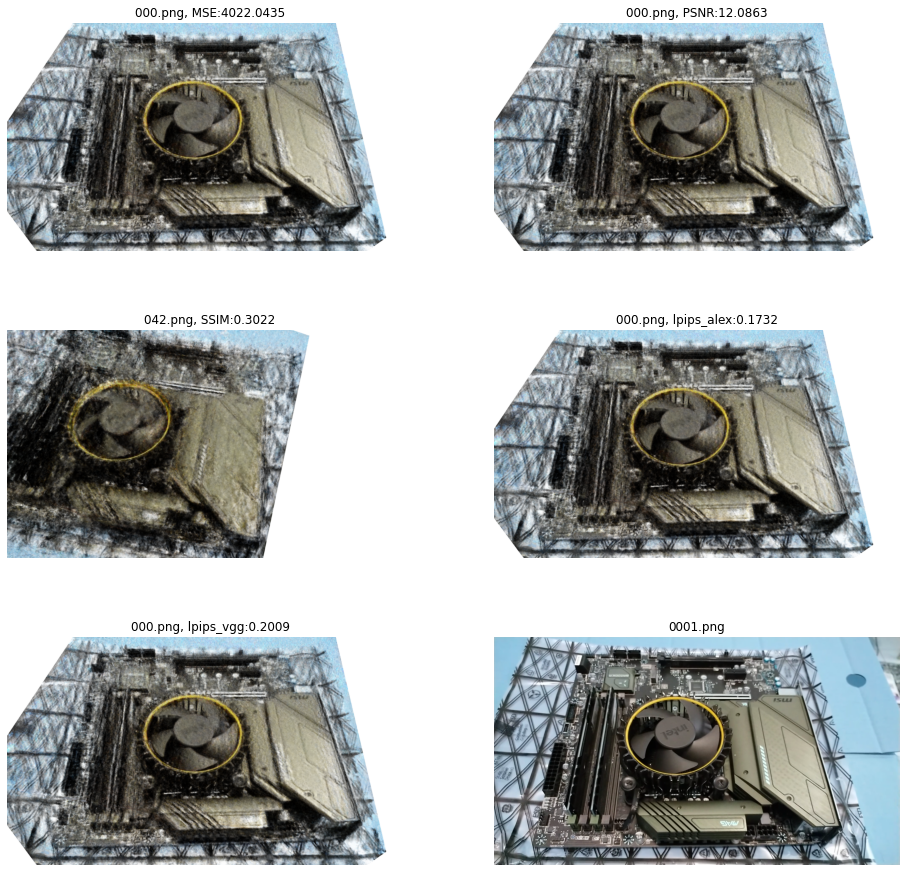

In [78]:
plt.figure(figsize=(16,16))
for i in range(6):
  ax = plt.subplot(3,2,i+1)
  if i==5:
    ax.set_title(img_real)
    plt.imshow(img1)
  else:
    ax.set_title(name[i])
    plt.imshow(cv2.imread(os.path.join(folder_fake,list(df3['name'])[i])))
  plt.axis('off')

plt.show()